In [6]:
from helpers import *
import numpy as np

#sns.set_palette('colorblind')
#sns.set_style('whitegrid')
sns.set_theme()
sns.set_palette("colorblind")

mpl.rcParams["axes.titlesize"] = 12.
mpl.rcParams["axes.labelsize"] = 12.
mpl.rcParams["axes.titleweight"] = "bold"
mpl.rcParams["axes.labelweight"] = "bold"
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = "serif"
mpl.rcParams['font.weight'] = "bold"

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import matplotlib as mpl

ALGOS = [
    "C3PO",
    "C-TRPO",
    "CPO",
    "PPO-Lag",
    "CPPO-PID",
    "P2BPO",
    "P3O",
    "PPO",
]
# A previous name for the algorithm was "W-Learning", 
# due to its use of Lambert's W function to compute the policy update.
algos_replace = [
    "w-learning-linear (w-learning)",
    "c-trpo-hyst (ablation)",
    "cpo (benchmark)",
    "ppo_lag (benchmark)",
    "cppo_pid (benchmark)",
    "p2bpo (c3po-baselines)",
    "p3o (benchmark)",
    "ppo (benchmark)"
]

ENVS = [
    "SafetyAntVelocity-v1", 
    "SafetyHalfCheetahVelocity-v1",
    "SafetyHumanoidVelocity-v1",
    "SafetyHopperVelocity-v1",
    "SafetyCarButton1-v0", 
    "SafetyPointGoal1-v0",
    "SafetyRacecarCircle1-v0",
    "SafetyPointPush1-v0"
]

metrics = [
    "Metrics/EpRet",  # normalize: PPO
    "Metrics/EpCost",  # normalize: cost threshold/limit
]

def get_df(
    algo_subset=("cpo"), 
    experiments=("benchmark"), 
    env_subset=None
):
    df = pd.DataFrame()
    for exp in experiments:
        try:
            bm_folder = os.path.join("..", "data", "runs", exp)
            envs = [f for f in os.listdir(bm_folder) if not f.startswith('.') and not f.endswith('.pdf')]
            envs = set(envs).intersection(env_subset) if env_subset else envs
        except FileNotFoundError:
            print("Not found")
            continue
        for env in envs:
            env_folder = os.path.join(bm_folder, env)
            algos = [f for f in os.listdir(env_folder) if not f.startswith('.') and not f.endswith('.pdf')]
            algos = set(algos).intersection(algo_subset) if algo_subset else algos
            for algo in algos:
                algo_folder = os.path.join(env_folder, algo)
                for seed in [f for f in os.listdir(algo_folder) if not f.startswith('.') and not f.endswith('.pdf')]:
                    progress_csv = os.path.join(algo_folder, seed, "progress.csv")
                    try:
                        new_df = pd.read_csv(progress_csv)
                        new_df["seed"] = seed
                        new_df["algo"] = algo + f" ({exp})"
                        new_df["env"] = env
                        new_df["exp"] = exp
                        # new_df = new_df.sort_values(by=['Train/TotalSteps'], ascending=True)
                        df = pd.concat([df, new_df], ignore_index=True)
                    except (pd.errors.EmptyDataError, pd.errors.ParserError) as e:
                        continue
    
    return df


def plot_env(df, env, xmax=10e6, diagnostics=True, cost_ci=True, 
             alpha=1., start_others_at=2, plot_cost_limit=True):
    
    df = df[(df["env"] == env)]
    
    _, axs = plt.subplots(1, 3, figsize=(10, 3), layout = 'tight')
    
    sns.lineplot(df, x="Train/TotalSteps", y="Metrics/EpCost", ax=axs[1], hue="algo")
    sns.lineplot(df, x="Train/TotalSteps", y="Metrics/EpRet", ax=axs[0], hue="algo")
    sns.lineplot(df, x="Train/TotalSteps", y="Metrics/EpCumCostViolation", ax=axs[2], hue="algo")
    
    axs[1].plot([0, xmax],[25,25], linestyle="dashed", label="cost limit", color="black")
    
    axs[1].set_ylim(0, ymax=100)
    # axs[2].set_ylim(0, ymax=1e6)
    
    axs[0].set_xlim(0, xmax=xmax)
    axs[1].set_xlim(0, xmax=xmax)
    axs[2].set_xlim(0, xmax=xmax)

    handles, labels = axs[1].get_legend_handles_labels()
    
    axs[0].legend(handles=handles, labels=labels, prop={'size': 6.5})
    axs[1].legend([],[], frameon=False)
    axs[2].legend([],[], frameon=False)
    
    r_axs = axs
     
    if diagnostics:
        metrics = ["Loss/Loss_cost_critic", "Train/KL", "Train/target_div", "Train/div"]
        _, axs = plt.subplots(1, len(metrics), figsize=(10, 3))

        for ax, metric in zip(axs, metrics):
            if metric in df.columns:
                sns.lineplot(df[df["algo"] == "C-TRPO"], x="Train/TotalSteps", y=metric, ax=ax, hue="algo")
    
    axs[0].set_ylabel("Return")
    axs[1].set_ylabel("Cost")
    axs[2].set_ylabel("Cost Regret")

    for ax in axs:
        ax.set_xlabel("Steps")
    
    return r_axs

In [26]:
df = get_df(algo_subset = ("w-learning-linear", "c-trpo-hyst", "cpo", "p2bpo", "cppo_pid", "ppo_lag", "p3o", "ppo"),
            env_subset = ENVS,
            experiments = ("benchmark", "w-learning", "ablation", "c3po-baselines"))
df = df.replace(algos_replace, ALGOS)
df['algo'] = pd.Categorical(df['algo'], ALGOS)
df = df.sort_values(by=['algo'])
df

,Metrics/EpRet,Metrics/EpCost,Metrics/EpLen,Metrics/EpCostRegret,Train/Epoch,Train/TotalSteps,Train/StopIter,Train/KL,Train/LagragianMultiplier,Train/LR,...,Misc/xHx,Misc/gradient_norm,Misc/H_inv_g,Misc/AcceptanceStep,Train/Kappa,Train/div,Train/target_div,Misc/optim_case,Loss/Loss_actor_r,Loss/Loss_actor_c
115001,-0.421053,33.171328,500.000000,1423.950000,2,40000,1.0,0.010540,0.001,0.000299,...,NaN,NaN,NaN,NaN,0.509,NaN,NaN,NaN,NaN,NaN
113336,4690.651773,3.718462,871.315385,23.923077,337,6740000,1.0,0.019862,0.001,0.000098,...,NaN,NaN,NaN,NaN,3.524,NaN,NaN,NaN,NaN,NaN
113335,4529.786988,1.960000,842.617273,3.090909,336,6720000,1.0,0.023025,0.001,0.000098,...,NaN,NaN,NaN,NaN,3.515,NaN,NaN,NaN,NaN,NaN
113334,4343.469469,0.794783,808.254783,0.000000,335,6700000,1.0,0.018595,0.001,0.000099,...,NaN,NaN,NaN,NaN,3.506,NaN,NaN,NaN,NaN,NaN
113333,4411.806849,0.554815,820.300741,0.000000,334,6680000,2.0,0.010372,0.001,0.000100,...,NaN,NaN,NaN,NaN,3.497,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95004,2.200887,101.282000,1000.000000,4197.850000,5,100000,28.0,0.021478,NaN,0.000297,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95005,3.171970,83.549000,1000.000000,3271.300000,6,120000,19.0,0.020119,NaN,0.000296,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95006,3.650277,86.135000,1000.000000,3359.750000,7,140000,24.0,0.020191,NaN,0.000296,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34999,1840.337981,447.594419,463.365581,21129.720930,500,10000000,40.0,0.003541,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
import scipy
import numpy as np

normalized_score_dict = {}

for metric in metrics:
    normalized_score_dict[metric] = {}
    for algo in ALGOS:
        normalized_score_dict[metric][algo] = np.zeros((5, len(ENVS)))
        for i, env in enumerate(ENVS):
            df_filtered = df[df["Train/TotalSteps"] == 10000000]
            df_filtered = df_filtered[df_filtered["env"] == env]
            if metric == "Metrics/EpRet":
                norm = df_filtered[df_filtered["algo"]=="PPO"][metric].mean()
            else:
                norm = 25.0
            data = np.array(df_filtered[df_filtered["algo"]==algo][metric])
            if not data.size == 0:
                normalized_score_dict[metric][algo][:len(data),i] = data / norm
            else:
                print(f"Warning: empty data for {algo}, {env}")

normalized_score_dict


{'Metrics/EpRet': {'C3PO': array([[0.55483801, 0.42855151, 0.87593914, 0.89996227, 0.14537173,
          0.90413193, 0.64063924, 1.01363525],
         [0.5666211 , 0.24256108, 0.85462825, 0.91495646, 0.09733592,
          0.94152741, 0.08423355, 5.82012046],
         [0.56190847, 0.42005561, 0.85386354, 0.89620733, 0.1236953 ,
          0.88542886, 0.71089598, 0.59927882],
         [0.56283854, 0.42533184, 0.85580152, 0.93603401, 0.11039576,
          0.89693072, 0.79284776, 7.3501257 ],
         [0.574618  , 0.24366024, 0.87772095, 0.91975619, 0.17679034,
          0.88860224, 0.56668847, 7.4039359 ]]),
  'C-TRPO': array([[ 0.55717952,  0.42669984,  0.90554973,  0.2329602 ,  0.06119686,
           0.74534   ,  0.69804277,  0.71654115],
         [ 0.55539136,  0.42372691,  0.89605844,  0.91518262,  0.07429558,
           0.75826387,  0.83206393, 10.95883726],
         [ 0.55591389,  0.41178906,  0.9605135 ,  0.92818465,  0.07069733,
           0.67918351,  0.73684746,  0.666305  ],
   

In [28]:
from rliable import library as rly
from rliable import metrics as rl_metrics
from rliable import plot_utils

aggregate_scores, aggregate_score_cis = {}, {}

metric_names = [
    "Reward", 
    "Final Cost",
]

metrics = [
    "Metrics/EpRet",  # normalize: PPO
    "Metrics/EpCost",  # normalize: cost threshold/limit
]

for metric, metric_name in zip(metrics, metric_names):
    aggregate_scores[metric_name], aggregate_score_cis[metric_name] = rly.get_interval_estimates(
        normalized_score_dict[metric], 
        rl_metrics.aggregate_iqm, 
        reps=10000
    )

In [29]:
as_df = pd.DataFrame(aggregate_scores).melt(ignore_index=False).reset_index()
as_df = as_df.rename(columns={"index": "algo", "variable": "metric"})

as_ci_df = pd.DataFrame(aggregate_score_cis).melt(ignore_index=False).reset_index()
as_ci_df = as_ci_df.rename(columns={"index": "algo", "variable": "metric", "value": "ci"})
as_ci_df


,algo,metric,ci
0,C3PO,Reward,"[[0.6779085691526558], [0.7570144072631256]]"
1,C-TRPO,Reward,"[[0.5997804373052309], [0.7062300843062297]]"
2,CPO,Reward,"[[0.6341035242048364], [0.7308400772005575]]"
3,PPO-Lag,Reward,"[[0.416269902572687], [0.513878478255014]]"
4,CPPO-PID,Reward,"[[0.4602433936669942], [0.5683437234246176]]"
5,P2BPO,Reward,"[[0.6061121852947983], [0.7020025247863821]]"
6,P3O,Reward,"[[0.40247926199743056], [0.5046259946203829]]"
7,PPO,Reward,"[[0.9708323465130518], [1.0153803401375086]]"
8,C3PO,Final Cost,"[[0.47571856428571424], [0.6801351738095238]]"
9,C-TRPO,Final Cost,"[[0.6965820898400381], [0.8736446692904656]]"


/var/folders/n1/bxdrmv296493f6tbg9v8pjnh0000gn/T/ipykernel_79491/2467117188.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ctrpo = as_df[as_df["metric"] == metric_name][as_df["algo"] == "C-TRPO"]["value"]


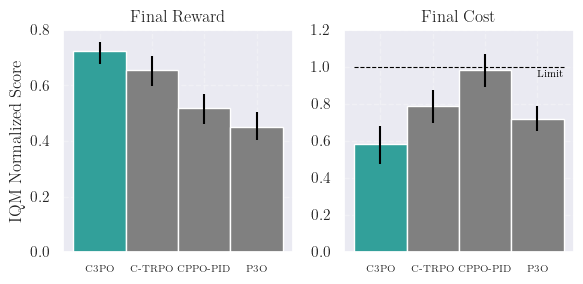

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharey=False)

algos_to_plot = ["C3PO", "C-TRPO", "CPPO-PID", "P3O"]

as_df1 = as_df[as_df["algo"].isin(algos_to_plot)]
as_ci_df1 = as_ci_df[as_ci_df["algo"].isin(algos_to_plot)]

for metric_name, ax in zip(metric_names, axs):
    
    sns.barplot(as_df1[as_df1["metric"] == metric_name], y="value", hue="algo", errorbar=("ci", False), ax=ax, hue_order=algos_to_plot, palette=["lightseagreen", "grey", "grey", "grey"])

    bars = [rect for rect in ax.get_children() if isinstance(rect, mpl.patches.Rectangle)]
    x = np.array(list(sorted([bar.xy[0] for bar in bars[:len(algos_to_plot)]])))
    y = np.array(as_df1[as_df1["metric"] == metric_name]["value"])
    yerr = np.stack(as_ci_df1[as_df1["metric"] == metric_name]["ci"])[:,:,0].transpose()
    ax.errorbar(x=x+bars[0].get_width()/2, y=y, yerr=abs(yerr - y), fmt=' ', color="black")
    ax.set_ylabel("IQM Normalized Score" if metric_name == "Reward" else "")
    ax.set_title(metric_name)
    #ax.set_xlabel("Algorithm")
    ax.set_xticks([bar.xy[0] + bars[0].get_width()/2 for bar in bars[:len(algos_to_plot)]])
    ax.set_xticklabels([algo for algo in algos_to_plot], rotation=0, ha='center', fontsize=7)
    ax.grid(True, linestyle='--', alpha=0.3)

    if metric_name == "Reward":
        ctrpo = as_df[as_df["metric"] == metric_name][as_df["algo"] == "C-TRPO"]["value"]
        #ax.plot([bars[0].xy[0], 0.4], [ctrpo, ctrpo], linestyle="dashed", zorder=10, color="darkgoldenrod", linewidth=0.8)
        #ax.text(0.4, ctrpo-0.01, "C-TRPO", size=7, rotation=0., ha="right", va="top", color="darkgoldenrod")
    else:
        ax.plot([bars[0].xy[0], 0.4], [1, 1], linestyle="dashed", zorder=10, color="black", linewidth=0.8)
        ax.text(0.4, 1-0.02, "Limit", size=7, rotation=0., ha="right", va="top", color="black")

# axs[1].plot([-0.41, 0.42], [1, 1], color="red", linestyle="dashed", label="limit", zorder=10)

handles, labels = axs[1].get_legend_handles_labels()

axs[0].legend([],[], frameon=False)
axs[1].legend([],[], frameon=False)

axs[0].set_title("Final Reward")
axs[1].set_title("Final Cost")

axs[0].set_ylim(0, 0.8)
axs[1].set_ylim(0, 1.2)

#axs[1].legend(handles, labels, prop={'size': 7})

plt.tight_layout()

plt.savefig(os.path.join("..", "graphics", f"benchmark.pdf"), dpi=600)

['C3PO', 'C-TRPO', 'CPO', 'PPO-Lag', 'CPPO-PID', 'P2BPO', 'P3O']


/var/folders/n1/bxdrmv296493f6tbg9v8pjnh0000gn/T/ipykernel_79491/250116664.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  as_ci_df1["algo"] = as_ci_df1["algo"]
/var/folders/n1/bxdrmv296493f6tbg9v8pjnh0000gn/T/ipykernel_79491/250116664.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ctrpo = as_df[as_df["metric"] == metric_name][as_df["algo"] == "C-TRPO"]["value"]


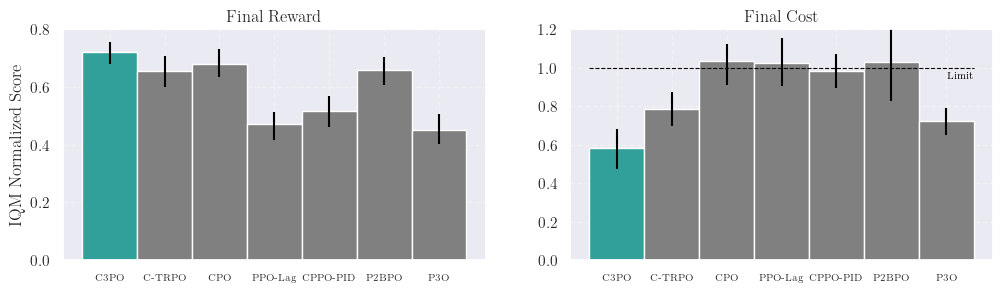

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3), sharey=False)

algos_to_plot = [algo for algo in ALGOS if algo not in ["PPO"]]
print(algos_to_plot)
as_df1 = as_df[as_df["algo"].isin(algos_to_plot)]
as_ci_df1 = as_ci_df[as_ci_df["algo"].isin(algos_to_plot)]
as_ci_df1["algo"] = as_ci_df1["algo"]

for metric_name, ax in zip(metric_names, axs):
    
    sns.barplot(as_df1[as_df1["metric"] == metric_name], y="value", hue="algo", errorbar=("ci", False), ax=ax, hue_order=algos_to_plot, palette=["lightseagreen", "grey", "grey", "grey", "grey", "grey", "grey"])

    bars = [rect for rect in ax.get_children() if isinstance(rect, mpl.patches.Rectangle)]
    x = np.array(list(sorted([bar.xy[0] for bar in bars[:len(algos_to_plot)]])))
    y = np.array(as_df1[as_df1["metric"] == metric_name]["value"])
    yerr = np.stack(as_ci_df1[as_df1["metric"] == metric_name]["ci"])[:,:,0].transpose()
    ax.errorbar(x=x+bars[0].get_width()/2, y=y, yerr=abs(yerr - y), fmt=' ', color="black")
    ax.set_ylabel("IQM Normalized Score" if metric_name == "Reward" else "")
    ax.set_title(metric_name)
    #ax.set_xlabel("Algorithm")
    ax.set_xticks([bar.xy[0] + bars[0].get_width()/2 for bar in bars[:len(algos_to_plot)]])
    ax.set_xticklabels([algo for algo in algos_to_plot], rotation=0, ha='center', fontsize=7)
    ax.grid(True, linestyle='--', alpha=0.3)

    if metric_name == "Reward":
        ctrpo = as_df[as_df["metric"] == metric_name][as_df["algo"] == "C-TRPO"]["value"]
        #ax.plot([bars[0].xy[0], 0.4], [ctrpo, ctrpo], linestyle="dashed", zorder=10, color="darkgoldenrod", linewidth=0.8)
        #ax.text(0.4, ctrpo-0.01, "C-TRPO", size=7, rotation=0., ha="right", va="top", color="darkgoldenrod")
    else:
        ax.plot([bars[0].xy[0], 0.4], [1, 1], linestyle="dashed", zorder=10, color="black", linewidth=0.8)
        ax.text(0.4, 1-0.02, "Limit", size=7, rotation=0., ha="right", va="top", color="black")

# axs[1].plot([-0.41, 0.42], [1, 1], color="red", linestyle="dashed", label="limit", zorder=10)

handles, labels = axs[1].get_legend_handles_labels()

axs[0].legend([],[], frameon=False)
axs[1].legend([],[], frameon=False)

axs[0].set_title("Final Reward")
axs[1].set_title("Final Cost")

axs[0].set_ylim(0, 0.8)
axs[1].set_ylim(0, 1.2)

#axs[1].legend(handles, labels, prop={'size': 7})

#plt.tight_layout()

plt.savefig(os.path.join("..", "graphics", f"benchmark_more.pdf"), dpi=600)

In [35]:
import numpy as np

metrics = [
    "Metrics/EpRet",  # normalize: PPO
    "Metrics/EpCost",  # normalize: cost threshold/limit
]

normalized_score_dict_samples = {}

steps = np.array(range(1, 11))*1_000_000

for i, env in enumerate(ENVS):
    normalized_score_dict_samples[env] = {}
    for metric in metrics:
        normalized_score_dict_samples[env][metric] = {}
        for algo in ALGOS:
            normalized_score_dict_samples[env][metric][algo] = np.zeros((5, 10))
            for j, step in enumerate(steps):
                # display(df_filtered)
                df_filtered = df[df["env"] == env]
                data = np.array(df_filtered[(df_filtered["algo"]==algo) & (df_filtered["Train/TotalSteps"] == step)][metric])
                if not data.size == 0:
                    normalized_score_dict_samples[env][metric][algo][:,j] = data
                else:
                    print(f"Warning: empty data for {algo}, {env}")

this takes a couple minutes to run:

In [36]:
import pickle

LOAD_DATA = False  # Set to True to load precomputed IQM scores and confidence intervals

if LOAD_DATA:
    with open(os.path.join("..", "data", "runs", "iqm_envs_c3po.pickle"), "rb") as f:
        iqm_scores, iqm_cis = pickle.load(f)
else:
    from rliable import library as rly
    from rliable import metrics as rl_metrics
    from rliable import plot_utils

    iqm_scores, iqm_cis = {}, {}

    for env in ENVS:
        print(f"Compute IQM scores and confidence intervals for {env}:", end="")
        iqm_scores[env] = {}
        iqm_cis[env] = {}
        for metric, metric_name in zip(metrics, metric_names):
            print(f" ...{metric_name}", end="")
            iqm = lambda scores: np.array([rl_metrics.aggregate_iqm(scores[..., frame])
                                        for frame in range(scores.shape[-1])])

            iqm_scores[env][metric_name], iqm_cis[env][metric_name] = rly.get_interval_estimates(
            normalized_score_dict_samples[env][metric], iqm, reps=50000)
            print(f", ", end="")
        print("")
    with open(os.path.join("..", "data", "runs", "iqm_envs_c3po.pickle"), "wb") as f:
        pickle.dump((iqm_scores, iqm_cis), f)

Compute IQM scores and confidence intervals for SafetyAntVelocity-v1: ...Reward,  ...Final Cost, 
Compute IQM scores and confidence intervals for SafetyHalfCheetahVelocity-v1: ...Reward,  ...Final Cost, 
Compute IQM scores and confidence intervals for SafetyHumanoidVelocity-v1: ...Reward,  ...Final Cost, 
Compute IQM scores and confidence intervals for SafetyHopperVelocity-v1: ...Reward,  ...Final Cost, 
Compute IQM scores and confidence intervals for SafetyCarButton1-v0: ...Reward,  ...Final Cost, 
Compute IQM scores and confidence intervals for SafetyPointGoal1-v0: ...Reward,  ...Final Cost, 
Compute IQM scores and confidence intervals for SafetyRacecarCircle1-v0: ...Reward,  ...Final Cost, 
Compute IQM scores and confidence intervals for SafetyPointPush1-v0: ...Reward,  ...Final Cost, 


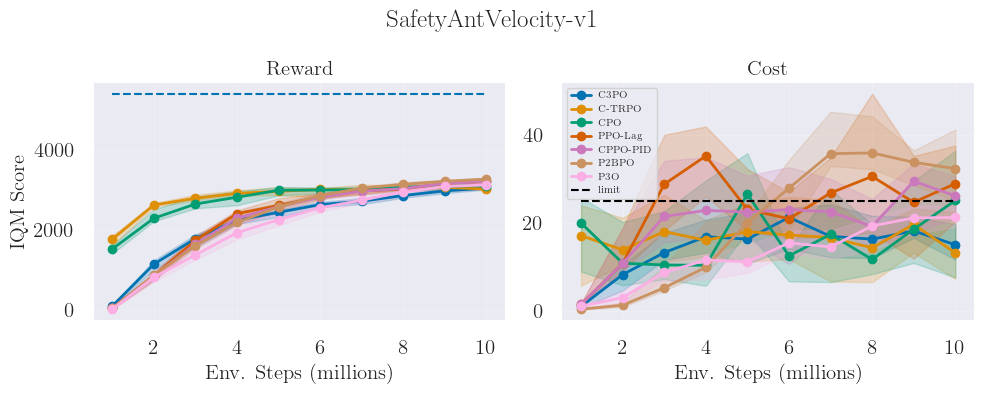

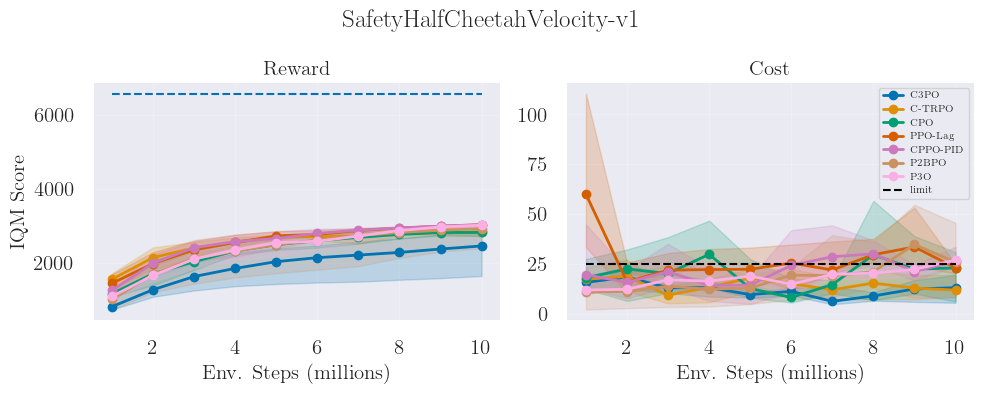

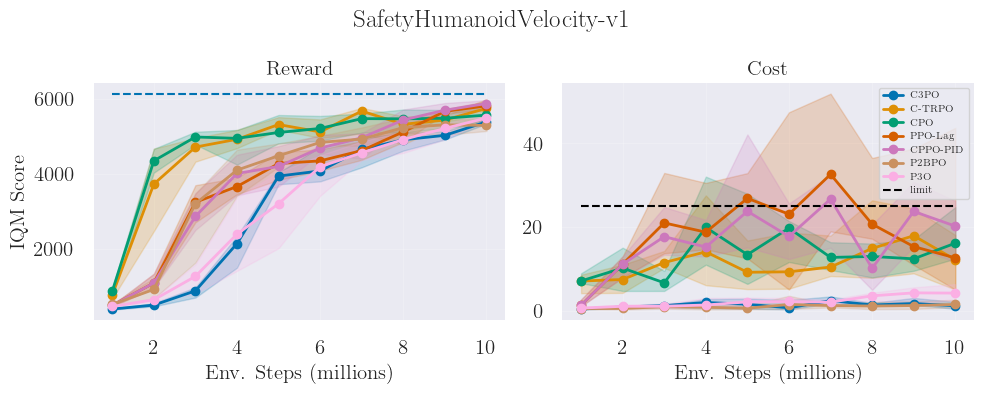

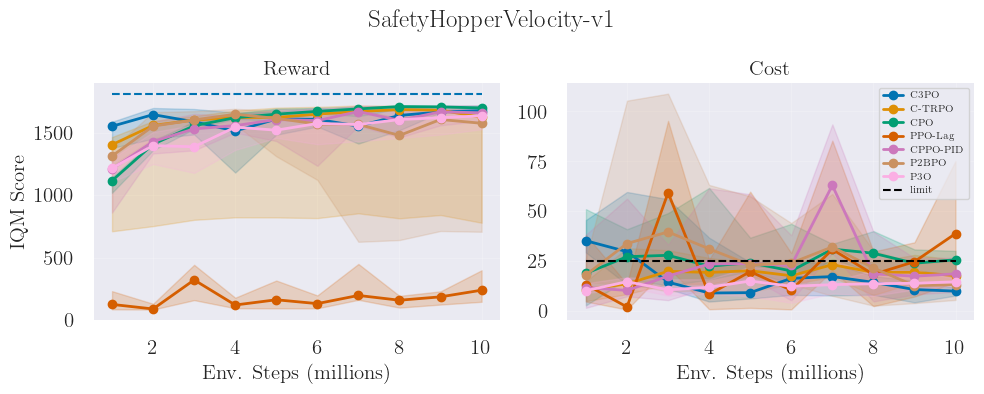

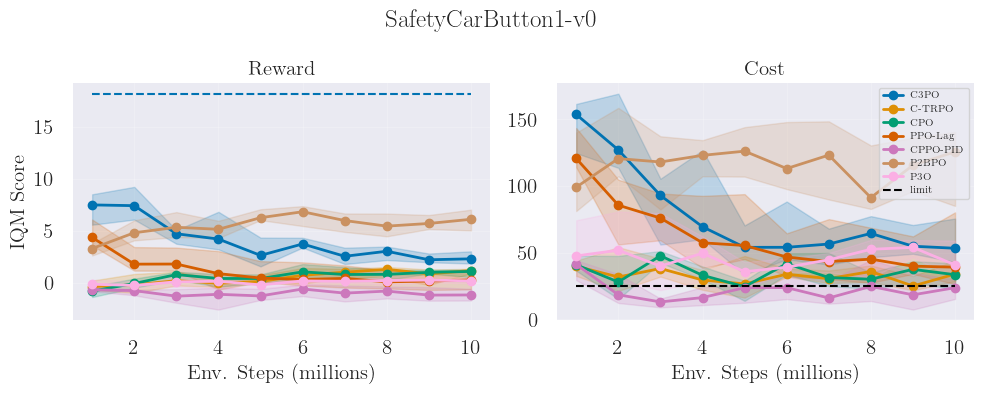

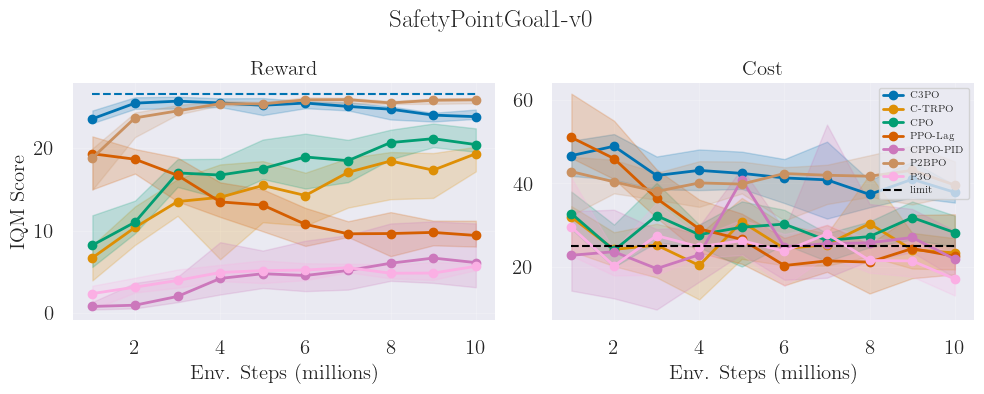

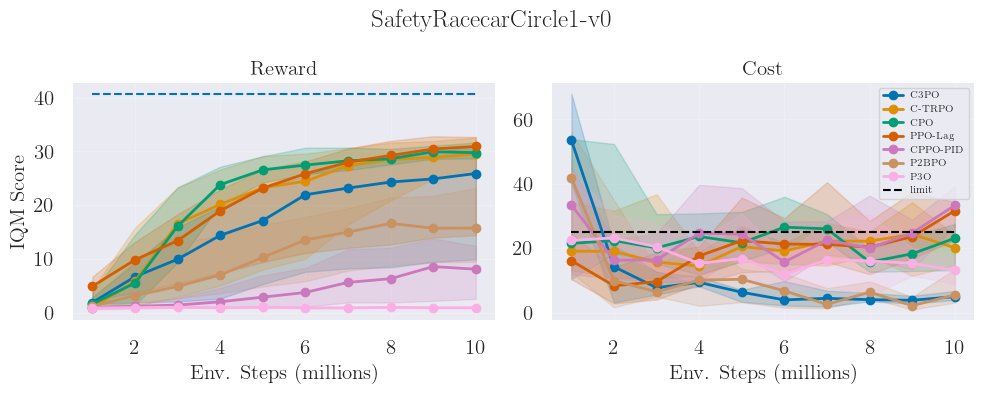

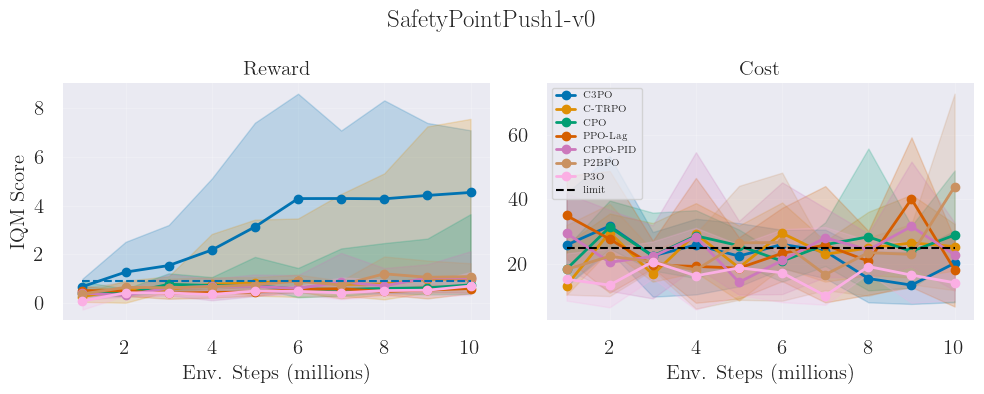

In [37]:
from rliable import library as rly
from rliable import metrics as rl_metrics
from rliable import plot_utils

algos_to_plot = [algo for algo in ALGOS if algo not in ["PPO"]]

metric_names = [
    "Reward", 
    "Final Cost",
]

metrics = [
    "Metrics/EpRet",  # normalize: PPO
    "Metrics/EpCost",  # normalize: cost threshold/limit
]

for env in ENVS:
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    for i, (metric_name, ax) in enumerate(zip(metric_names, axs)):
        plot_utils.plot_sample_efficiency_curve(
            np.array(range(1,11)), iqm_scores[env][metric_name], iqm_cis[env][metric_name], algorithms=algos_to_plot, ax=ax,
            xlabel=r'Env. Steps (millions)',
            ylabel="IQM Score" if i == 0 else "",
            labelsize=15,
            ticklabelsize=15,
            # legend=True if (i == 0) else False,
        )

        if metric_name == "Cumulative Cost":
            ax.set_title("Cost Regret", fontsize=15)
        elif metric_name == "Final Cost":
            ax.set_title("Cost", fontsize=15)
        else:
            ax.set_title("Reward", fontsize=15)
        ax.set_xticks([2, 4, 6, 8, 10])
    fig.suptitle(env, fontsize=18)
    
    ppo_score = iqm_scores[env]["Reward"]["PPO"][-1]
    axs[0].plot([1, 10], [ppo_score, ppo_score], linestyle="dashed", label="PPO", zorder=10)
    axs[1].plot([1, 10], [25.0, 25.0], color="black", linestyle="dashed", label="limit", zorder=10)

    plt.legend(prop={'size': 7})

    plt.tight_layout()

    plt.savefig(os.path.join("..", "graphics", f"benchmark_samples_{env}.pdf"), dpi=600)

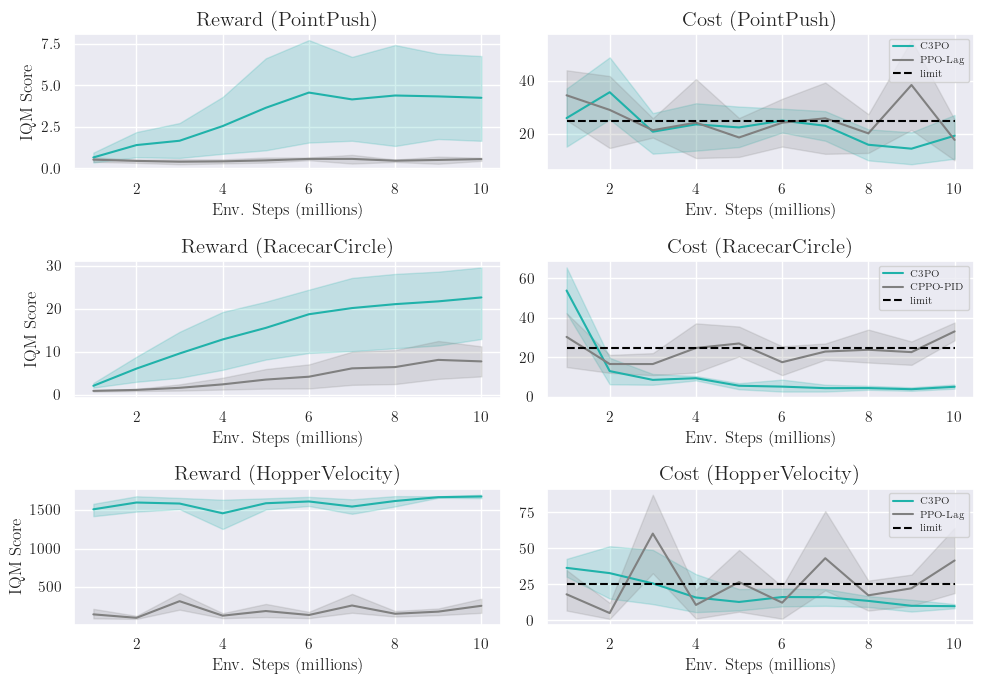

In [38]:
df = get_df(algo_subset = (
    "w-learning-linear",
    "ppo_lag", 
    "cppo_pid"
    ),
            env_subset = ENVS,
            experiments = ("benchmark", "w-learning"))
algos_to_plot = [
    "C3PO",
    "PPO-Lag",
    "CPPO-PID"
]
df = df.replace([
    "w-learning-linear (w-learning)", 
    "ppo_lag (benchmark)", 
    "cppo_pid (benchmark)"
], algos_to_plot)
#df['algo'] = pd.Categorical(df['algo'], algos_to_plot)
df = df.sort_values(by=['algo'])
df = df[df["Train/TotalSteps"] % 1000000 == 0]

envs_to_plot = ["SafetyPointPush1-v0", "SafetyRacecarCircle1-v0", "SafetyHopperVelocity-v1"]

metric_names = [
    "Reward", 
    "Cost",
]

metrics = [
    "Metrics/EpRet",  # normalize: PPO
    "Metrics/EpCost",  # normalize: cost threshold/limit
]
fig, axss = plt.subplots(3, 2, figsize=(10, 7))
for env, axs, algos in zip(envs_to_plot, axss, [["C3PO", "PPO-Lag"], ["C3PO", "CPPO-PID"], ["C3PO", "PPO-Lag"]]):

    for i, (metric_name, metric, ax) in enumerate(zip(metric_names, metrics, axs)):
        dfn = df[df["algo"].isin(algos)]

        sns.lineplot(dfn[dfn["env"] == env], x="Train/TotalSteps", y=metric, ax=ax, hue="algo", hue_order=algos, palette=["lightseagreen", "grey"])

        if metric_name == "Cost":
            ax.set_title(f"Cost ({env.strip('Safety').strip('1-v0')})", fontsize=15)
            ax.set_ylabel("")
        else:
            ax.set_title(f"Reward ({env.strip('Safety').strip('1-v0')})", fontsize=15)
            ax.set_ylabel("IQM Score")
        ax.set_xticks([2000000, 4000000, 6000000, 8000000, 10000000])
        ax.set_xticklabels([2, 4, 6, 8, 10])
        ax.set_xlabel("Env. Steps (millions)")
    
    axs[1].plot([1000000, 10000000], [25.0, 25.0], color="black", linestyle="dashed", label="limit", zorder=10)
    
    axs[0].legend([], [], frameon=False)
    
    axs[1].legend(prop={'size': 7})

    plt.tight_layout()

plt.savefig(os.path.join("..", "graphics", f"lag_failure.pdf"), dpi=600)